In [1]:

import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import folium
from folium.plugins import MiniMap
from folium.plugins import MeasureControl
from folium.plugins import MarkerCluster


In [2]:
output_path = "./figures/"

In [3]:
# load data
sites = gpd.read_parquet('../data/processed/moz.parquet')  
graph = ox.load_graphml(filepath="../data/processed/moz.graphml")
health_facilities = gpd.read_parquet('../data/processed/moz_healthsites.parquet') 
bbox = gpd.read_file("../data/external/Moz-adm0.gpkg").total_bounds


In [4]:
# country_border = gpd.read_file('../data/external/Moz-adm0.gpkg')
# country_polygon = country_border.geometry.iloc[0]


In [5]:
# graph_all = ox.graph.graph_from_xml('../data/external/mozambique.osm')
# graph_all  = ox.truncate.truncate_graph_polygon(G=graph_all, polygon=country_polygon)
# ox.io.save_graphml(G=graph_all, filepath="../data/processed/moz.graphml")

In [6]:
# get data for area of focus
bbox = gpd.read_file("../data/external/Mandruzi.geojson").total_bounds

graph_focus = ox.truncate.truncate_graph_bbox(graph, bbox=bbox)
health_facilities_focus = gpd.clip(health_facilities, bbox)
sites_focus = sites[sites['1.1.d.1 Site Name'] == 'Mandruzi']
path = ox.routing.route_to_gdf(G=graph, route=sites_focus['route'].item()) # for one site
sites_good = sites[sites['distance_meters'] != 0] # remove sites in health facilities (it was giving an error)

# create a gdf for all routes
routes_gdfs = []
for route in sites_good['route'].head(68):
    route_gdf = ox.routing.route_to_gdf(G=graph, route=route)
    routes_gdfs.append(route_gdf)

merged_routes_gdf = gpd.GeoDataFrame(pd.concat(routes_gdfs, ignore_index=True))


# route for Mandruzi
coords_list = [
    [(y, x) for x, y in geom.coords] if geom.geom_type != 'Point' else [(geom.y, geom.x)]
    for geom in path.geometry
]

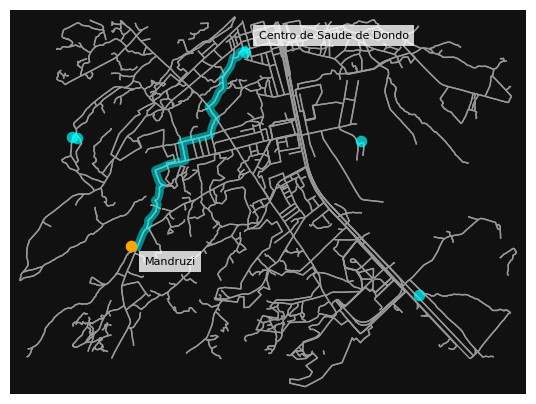

In [7]:

# orig = gdf[gdf['1.1.d.1 Site Name'] == 'Mandruzi']['nearest_node'].iloc[0]
# dest = gdf[gdf['1.1.d.1 Site Name'] == 'Mandruzi']['nearest_health_facility_node'].iloc[0]
# route = ox.shortest_path(graph, orig, dest, weight="length")

# prep the values
orig = sites_focus['nearest_node'].item()
orig_name = sites_focus['1.1.d.1 Site Name'].item()
dest = sites_focus['nearest_health_facility_node'].item()
dest_name = sites_focus['nearest_health_facility_name'].item()
route = sites_focus['route'].item()

# plot static map
fig, ax = ox.plot_graph_route(graph_focus, route, route_color="cyan", route_linewidth=6, node_size=0, orig_dest_size=0, show=False, close=False, figsize=(6.66,6.66))
health_facilities.plot(ax=ax, color='cyan', alpha=0.7, markersize=70, zorder=2, linewidth=0)
sites_focus.plot(ax=ax, color='orange', alpha=1, markersize=70, zorder=3, linewidth=0)

orig_point = Point(graph.nodes[orig]['x'], graph.nodes[orig]['y'])
dest_point = Point(graph.nodes[dest]['x'], graph.nodes[dest]['y'])

o = ax.text(orig_point.x+0.001, orig_point.y-0.002, 'Mandruzi', fontsize=8, color='black', va='center')
o.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))
d = ax.text(dest_point.x+0.002, dest_point.y+0.002, 'Centro de Saude de Dondo', fontsize=8, color='black', va='center')
d.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))

#ax.set_title("Mandruzi site - nearest health facility", fontsize=14)

fig.savefig(f"{output_path}moz-static-focus.svg", format="svg", bbox_inches='tight', dpi=120, pad_inches = 0.1)
fig.savefig(f"{output_path}moz-static-focus.png", format="png", bbox_inches='tight', dpi=300, pad_inches = 0)
plt.show()



In [8]:

health= [[point.xy[1][0], point.xy[0][0]] for point in health_facilities.geometry]

map = folium.Map(location=[ -19.630, 34.735], tiles="CartoDB dark_matter", zoom_start=14, max_bounds=False, control_scale=True, zoom_control='topleft') # or dark_matter
# folium.TileLayer("CartoDB dark_matter").add_to(map)
# map_title = "Mandruzi  is approx. 4km (49mins walk) to its nearest health facility"
# title_html = f'<h3 style="position:absolute;z-index:100000;left:10vw;color:#DCDCDC" >{map_title}</h1>'
# map.get_root().html.add_child(folium.Element(title_html))

# map health facilities
i = 0
for coordinates in health:
    map.add_child(
        folium.Marker(
            location=coordinates,
            tooltip="Type:"
            + str(health_facilities.iloc[0]["amenity"])
            + "<br>"
            + "Name: "
            + str(health_facilities.iloc[i]["name"]),
            icon=folium.Icon(icon="hospital", prefix="fa",color="green"),
        )
    )
    i = i + 1

marker = folium.Marker(
    location=[sites_focus.geometry.y.item(), sites_focus.geometry.x.item()],
    popup=folium.Popup("Site: " + str(sites_focus['1.1.d.1 Site Name'].item()), show=True),
    icon = folium.Icon(icon="building", prefix="fa",color="orange")
)
marker.add_to(map)

line = folium.PolyLine(tooltip="Distance: 4,049 metres", locations=coords_list, color='#00FFFF', weight=5, opacity=0.8)
line.add_to(map)

MiniMap(tile_layer="Cartodb positron", zoom_level_offset=-8).add_to(map)
map.add_child(MeasureControl())

map.save(f"{output_path}moz-dynamic-mandruzi.html")
map


In [9]:
# interactive map showing all sites, facilities and routes

health_list = [[point.xy[1][0], point.xy[0][0]] for point in health_facilities.geometry]
sites_list = [[point.xy[1][0], point.xy[0][0]] for point in sites.geometry]
routes_list = [[line.xy[1][0], line.xy[0][0]] for line in merged_routes_gdf.geometry]

map = folium.Map(location=[ -19.630, 34.735], tiles="CartoDB dark_matter", zoom_start=10, max_bounds=False, control_scale=True, zoom_control='topleft') # or dark_matter
marker_cluster1 = MarkerCluster().add_to(map)
marker_cluster2 = MarkerCluster().add_to(map)



# map health facilities
i = 0
for coordinates in health_list:
    marker_cluster1.add_child(
        folium.Marker(
            location=coordinates,
            tooltip="Type:"
            + str(health_facilities.iloc[0]["amenity"])
            + "<br>"
            + "Name: "
            + str(health_facilities.iloc[i]["name"]),
            icon=folium.Icon(icon="hospital", prefix="fa",color="green"),
        )
    )
    i = i + 1

# map sites
i = 0
for coordinates in sites_list:
    marker_cluster2.add_child(
        folium.Marker(
            location=coordinates,
            tooltip=
            "Name: "
            + str(sites.iloc[i]["1.1.d.1 Site Name"]),
            icon=folium.Icon(icon="building", prefix="fa",color="blue"),
        )
    )
    i = i + 1

# map routes
for _, row in merged_routes_gdf.iterrows():
    # Extract the coordinates from the LineString geometry
    coords = [(point[1], point[0]) for point in row.geometry.coords]
    # Add the PolyLine to the map
    folium.PolyLine(locations=coords, color='#00FFFF').add_to(map)

MiniMap(tile_layer="Cartodb positron", zoom_level_offset=-6).add_to(map)
map.add_child(MeasureControl())
marker_cluster = MarkerCluster().add_to(map)


map.save(f"{output_path}moz-dynamic-all.html")
map


In [10]:
sites.head(5)


SSID 1.1.d.1 Site Name  Longitude  Latitude Site status  \
9   MOZ_R013        Machacuari     33.301   -20.105        Open   
25  MOZ_R038       Muchambanha     33.323   -20.083        Open   
48  MOZ_R065      Nhamississua     33.307   -20.054        Open   
40  MOZ_R054             Gudza     33.335   -20.039        Open   
12  MOZ_R020            Javera     33.332   -20.020        Open   

    2.1.b.1 Total number of IDP individuals  \
9                                       115   
25                                      214   
48                                      182   
40                                      864   
12                                      134   

   How long does it take to reach the nearest health facility from the site?  \
9                                More than 60 minutes                          
25                               More than 60 minutes                          
48                               More than 60 minutes                          
40                               More than 60 minutes                          
12                                    31 - 60 minutes                          

                  geometry  longitude  latitude  nearest_node  \
9   POINT (33.301 -20.105)     33.301   -20.105    6403355793   
25  POINT (33.323 -20.083)     33.323   -20.083    6403360957   
48  POINT (33.307 -20.054)     33.307   -20.054    6402220991   
40  POINT (33.335 -20.039)     33.335   -20.039    6402282789   
12   POINT (33.332 -20.02)     33.332   -20.020    6400301453   

    nearest_health_facility_node nearest_health_facility_name  \
9                     6441867825     Posto de Saude da Missao   
25                    6441867825     Posto de Saude da Missao   
48                    6441867825     Posto de Saude da Missao   
40                    6441867825     Posto de Saude da Missao   
12                    6441867825     Posto de Saude da Missao   

    distance_meters                                              route  \
9      17785.851189  [6403355793, 6403355481, 6403356063, 640335605...   
25     20292.681516  [6403360957, 6403360953, 6403360984, 654975005...   
48     13429.136848  [6402220991, 6402221339, 6402221334, 640222142...   
40     14608.555381  [6402282789, 587735325, 6402240775, 6402282876...   
12      8878.354648  [6400301453, 6402499818, 6547962028, 640117872...   

    walking_time_minutes  
9             213.259607  
25            243.317524  
48            161.020826  
40            175.162535  
12            106.455092

In [11]:
sites['walking_time_minutes'].median().item()

127.98040191138392

In [12]:
median_value = sites['walking_time_minutes'].median().item()

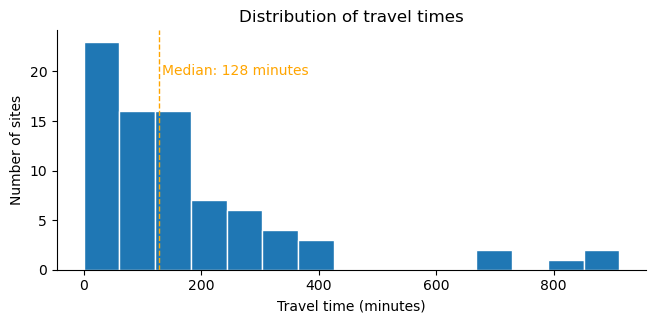

In [13]:
fig, ax = plt.subplots(figsize=(6.66,3.33))
ax.hist(sites['walking_time_minutes'], bins=15, edgecolor='white')
ax.set_xlabel('Travel time (minutes)')
ax.set_ylabel('Number of sites')
ax.set_title('Distribution of travel times')
#ax.set_xticks(range(0, 15, 4))
#ax.set_xticklabels(bins[::4].strftime('%H:%M'), rotation=45)
ax.spines[['top','right']].set_visible(False)

ax.axvline(median_value, color='orange', linestyle='dashed', linewidth=1)
ax.text( median_value + 5, 20, f'Median: {median_value:.0f} minutes', color='orange', va='center')

fig.tight_layout()
fig.savefig("../notebooks/figures/moz-static-hist-computed.svg", format="svg", bbox_inches='tight', dpi=120, pad_inches = 0.1)

plt.show()